# Fits of the phase boundary of TmVO4 extracted from MCE data

## Importation of modules and data

In [1]:
from datetime import date
import os

import numpy as np
import pandas as pd

from lmfit import minimize, Parameters

import matplotlib as mpl
from matplotlib import pyplot as plt, rc, rcParams#, ticker
print(mpl.matplotlib_fname())

C:\Users\Pierre\.matplotlib\matplotlibrc


In [2]:
# inline interactive plotting using the nbAgg backend; 
%matplotlib notebook
rcParams['figure.subplot.hspace'] = 0# remove vertical space between subplots
text = {'usetex': True}
# rc('text', **text)
today = date.today()

In [3]:
# Define sample parameters 
# He3 sample is TmVO4-LS5200-needles, DR sample is TmVO4-LS5228-DR-HC1807
samples = {0:'TmVO4-LS5200',
           1:'TmVO4-LS5228-DR-HC1807'}

mce_data_dir = {samples[0]:r'C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2017-07_TmVO4_Cp_MCE\2017-07-28--31\Massaic_MCE\Extracted_critical_fields', 
               samples[1]:r'C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2018-08_TmVO4-LS5228\Extracted_critical_fields'}

mce_data_file = {samples[0]:'2021-05-26_TmVO4-LS5200_Hc_all_runs.csv',
                samples[1]:'2021-05-27_TmVO4-LS5228-DR-HC1807_Hc_all_runs.csv'}

cp_data_dir = {samples[0]:r'C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2017-07_TmVO4_Cp_MCE\2017-07-28--31\2017-07-28_Cp', 
               samples[1]:r'C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2018-08_TmVO4-LS5228'}

cp_data_file = {samples[0]:r'TmVO4_Mosaic_2017-07-28.dat',
                 samples[1]:r'2018-07-31_TmVO4-LS5228-DR-HC180731.dat'}

# Choose which sample to work with
sample = samples[0]

Nsamples = len(samples)# number of samples
Nsamples

2

In [4]:
mce_data_list = [None]*Nsamples
for idx in range(Nsamples):
    os.chdir(mce_data_dir[samples[idx]])
    print(os.getcwd())
    mce_data_list[idx] = pd.read_csv(mce_data_file[samples[idx]], comment='#')

mce_data = tuple(mce_data_list)
mce_data[idx]

C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2017-07_TmVO4_Cp_MCE\2017-07-28--31\Massaic_MCE\Extracted_critical_fields
C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2018-08_TmVO4-LS5228\Extracted_critical_fields


,Date,Run number,Sweeprate,Tbath,Hc_measured,Tc,dHc,deltaHc,deltaHcErr,rhc,Hc_inferred
0,2018-08-01,0,10.0,0.7,5243.541992,0.714026,38.871874,0.001232,0.007413,0.968,5075.748648
1,2018-08-01,0,10.0,0.9,5124.268066,0.903264,191.369223,0.009900,0.037346,0.968,4960.291488
2,2018-08-01,0,10.0,1.0,5094.531494,1.010896,191.369223,0.004018,0.037564,0.968,4931.506486
3,2018-08-01,0,10.0,1.2,4976.892334,1.215976,38.871874,-0.009422,0.007810,0.968,4817.631779
4,2018-08-01,0,10.0,1.4,4688.467285,1.425613,38.871874,-0.017803,0.008291,0.968,4538.436332
5,2018-08-01,0,10.0,1.6,4257.239746,1.644601,38.871874,-0.032237,0.009131,0.968,4121.008074
6,2018-08-01,0,10.0,1.8,3619.604004,1.864751,38.871874,-0.103493,0.010739,0.968,3503.776676
7,2018-08-01,0,20.0,0.6,5186.448486,0.599730,56.612661,0.015146,0.010915,0.968,5020.482135
8,2018-08-01,0,20.0,0.7,5274.552979,0.696963,56.612661,-0.003707,0.010733,0.968,5105.767283
9,2018-08-01,0,20.0,0.8,5241.564453,0.798219,56.612661,-0.002206,0.010801,0.968,5073.834391


In [5]:
cp_data_list = [None]*Nsamples
for idx in range(Nsamples):
    os.chdir(cp_data_dir[samples[idx]])
    print(os.getcwd())
    cp_data_list[idx] = pd.read_csv(cp_data_file[samples[idx]], header=13)

cp_data_list[idx]

C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2017-07_TmVO4_Cp_MCE\2017-07-28--31\2017-07-28_Cp
C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2018-08_TmVO4-LS5228


,Time Stamp (Seconds),Comment (),System Status (Code),Puck Temp (Kelvin),System Temp (Kelvin),Field (Oersted),Pressure (Torr),Sample Temp (Kelvin),Temp Rise (Kelvin),Samp HC (�J/K),...,Debye Temp Err (Kelvin),Cal Correction (Factor),Therm Resist (Ohms),Htr Resist (Ohms),Puck Resist (Ohms),Wire Cond (W/K),Meas Time (seconds),Temp Squared (K^2),Samp HC/Temp (�J/K/K),Addenda Offset HC (�J/K)
0,3.742245e+09,CALFILE: C:\QDDYNA~1\HEATCA~1\TempCal\DR\DRPuc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.742245e+09,NaN,833.0,3.76441,3.76441,0.338612,0.00001,3.803555,0.078882,0.185649,...,NaN,1.0,NaN,NaN,NaN,1.066914e-06,10.133878,14.467029,0.048809,0.0
2,3.742245e+09,NaN,833.0,3.76541,3.76541,0.362799,0.00001,3.801342,0.072214,0.198915,...,NaN,1.0,NaN,NaN,NaN,1.068278e-06,8.799080,14.450201,0.052328,0.0
3,3.742245e+09,NaN,833.0,3.76472,3.76472,0.374892,0.00001,3.799894,0.072121,0.205823,...,NaN,1.0,NaN,NaN,NaN,1.072738e-06,8.804304,14.439191,0.054166,0.0
4,3.742245e+09,NaN,833.0,3.14031,3.14031,0.399079,0.00001,3.176905,0.068255,0.341131,...,NaN,1.0,NaN,NaN,NaN,9.080605e-07,8.771423,10.092728,0.107378,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,3.742364e+09,NaN,833.0,1.17057,1.17057,4000.281000,0.00001,1.182976,0.024710,4.804381,...,NaN,1.0,NaN,NaN,NaN,2.615919e-07,39.515497,1.399432,4.061267,0.0
298,3.742364e+09,NaN,833.0,1.16935,1.16935,4000.257100,0.00001,1.183356,0.024776,4.815105,...,NaN,1.0,NaN,NaN,NaN,2.679236e-07,40.140417,1.400332,4.069024,0.0
299,3.742364e+09,NaN,833.0,1.10008,1.10008,4000.257100,0.00001,1.112846,0.023726,4.070775,...,NaN,1.0,NaN,NaN,NaN,2.398242e-07,39.055810,1.238425,3.657987,0.0
300,3.742364e+09,NaN,833.0,1.09996,1.09996,4000.305400,0.00001,1.113038,0.023350,4.117530,...,NaN,1.0,NaN,NaN,NaN,2.468568e-07,37.501623,1.238853,3.699363,0.0


In [6]:
for idx in range(Nsamples):
    for col in cp_data_list[idx].columns[10:11]:
        s = [s for s in col if ord(s)>128]

    for sidx in range(len(s)):
        cp_data_list[idx].columns = cp_data_list[idx].columns.str.replace(s[sidx],'u')
            
    print(cp_data_list[idx].columns, '\n')
    
cp_data = tuple(cp_data_list)

Index(['Time Stamp (Seconds)', 'Comment ()', 'System Status (Code)',
       'Puck Temp (Kelvin)', 'System Temp (Kelvin)', 'Field (Oersted)',
       'Pressure (Torr)', 'Sample Temp (Kelvin)', 'Temp Rise (Kelvin)',
       'Samp HC (uJ/K)', 'Samp HC Err (uJ/K)', 'Addenda HC (uJ/K)',
       'Addenda HC Err (uJ/K)', 'Total HC (uJ/K)', 'Total HC Err (uJ/K)',
       'Fit Deviation (ChiSquare)', 'Time Const tau1 (seconds)',
       'Time Const tau2 (seconds)', 'Sample Coupling (Percent)',
       'Debye Temp (Kelvin)', 'Debye Temp Err (Kelvin)',
       'Cal Correction (Factor)', 'Therm Resist (Ohms)', 'Htr Resist (Ohms)',
       'Puck Resist (Ohms)', 'Wire Cond (W/K)', 'Meas Time (seconds)',
       'Temp Squared (K^2)', 'Samp HC/Temp (uJ/K/K)',
       'Addenda Offset HC (uJ/K)'],
      dtype='object') 

Index(['Time Stamp (Seconds)', 'Comment ()', 'System Status (Code)',
       'Puck Temp (Kelvin)', 'System Temp (Kelvin)', 'Field (Oersted)',
       'Pressure (Torr)', 'Sample Temp (Kelvin)', 'Tem

## Plot data

### Plot functions

In [7]:
def cp_plot_settings(axis):
    axis.set_ylabel(r'$C_p$ (uJ/K)')
    axis.set_xlabel(r'$T$ (K)')
    axis.locator_params(nbins=6)
    
def pb_plot_settings(axis):
    axis.set_xlabel(r'$H$ (Oe)')
    axis.set_ylabel(r'$T$ (K)')
    axis.locator_params(nbins=6)

### Cp data

In [8]:
for var in ['Tcp', 'Hcp', 'Cp', 'CpErr', 'd1TCp', 'uhcp', 'Tm']:
    exec(f'{var}=[None]*2')

In [9]:
for idx in range(Nsamples):
    uhcp[idx] = np.unique(np.round(cp_data[idx]['Field (Oersted)'][cp_data[idx]['Field (Oersted)']>0]))
uhcp

[array([  10., 1000., 2000., 3000., 4000., 4500., 4750., 5000.]),
 array([   0., 2000., 4000.])]

In [10]:
for idx in range(Nsamples):
    Tcp[idx] = cp_data[idx]['Sample Temp (Kelvin)']
    Hcp[idx] = cp_data[idx]['Field (Oersted)']
    Cp[idx] = cp_data[idx]['Samp HC (uJ/K)']
    CpErr[idx] = cp_data[idx]['Samp HC Err (uJ/K)']

<IPython.core.display.Javascript object>


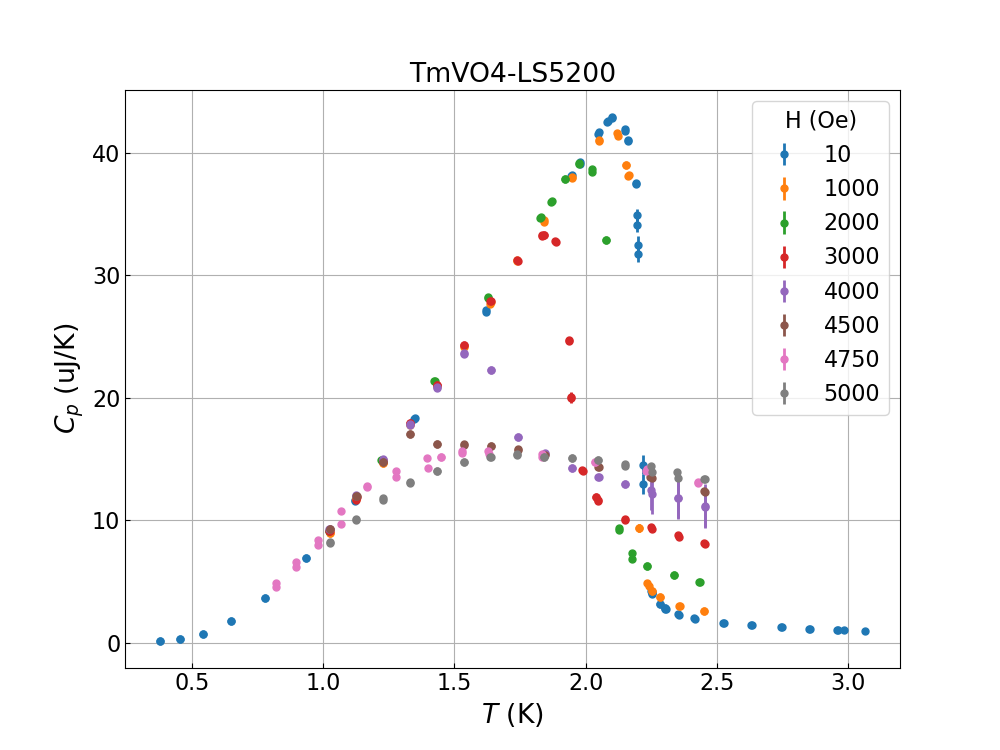

<IPython.core.display.Javascript object>


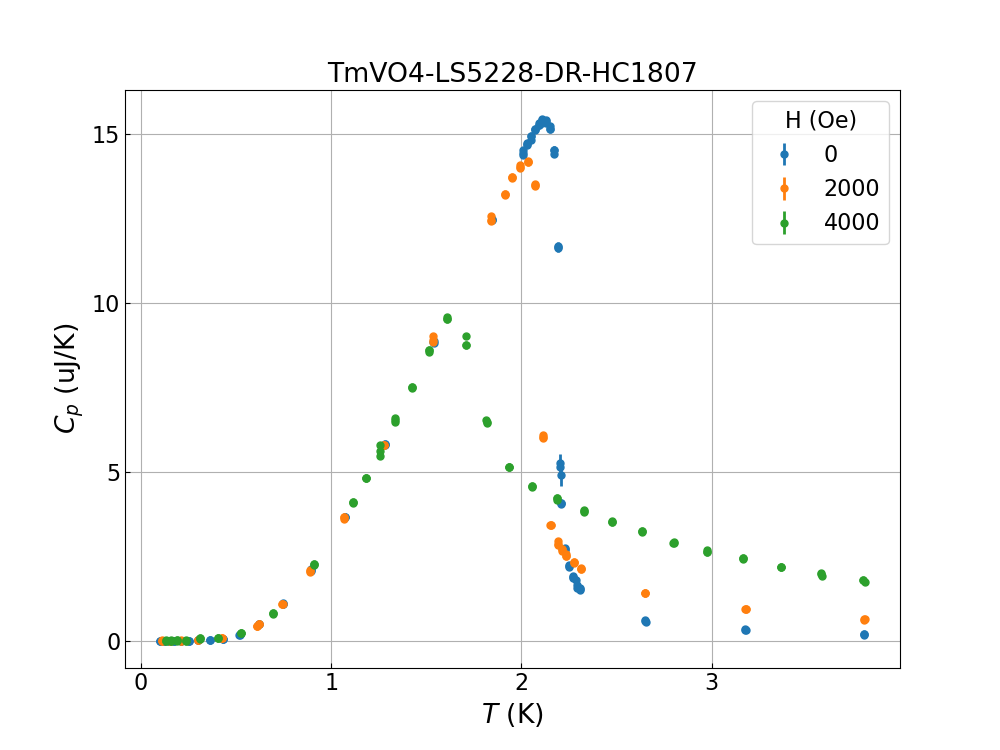

In [11]:
for idx in range(Nsamples):
    fig, ax = plt.subplots()
    cp_plot_settings(ax)
    plt.title(samples[idx])
    for uh in uhcp[idx]:
        cpsel = np.where(np.round(Hcp[idx])==uh)[0]
        plt.errorbar(Tcp[idx][cpsel], Cp[idx][cpsel], yerr=CpErr[idx][cpsel], 
                     marker='.', lw=0, elinewidth=2, label=round(uh))
    plt.legend(title='H (Oe)')

In [12]:
# k = 148#len(Tcp[idx])-1
# cp_data_list[idx].iloc[max(0,k-3):k+4]
Ttest = Tcp[idx].copy()
Ttest.values[:] = 0
Ttest

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
297    0.0
298    0.0
299    0.0
300    0.0
301    0.0
Name: Sample Temp (Kelvin), Length: 302, dtype: float64

#### Average data points measured at same temperature setpoint

In [13]:
def averageCp(relTsep, Tref, Cp, CpErr, H):
    # relTsep = Tsep = 6e-3
    T = Tref.copy()
    Tm = Tref.copy()
    Tm.values[:] = 0# set all values of Tm to 0
    Tsd = Tref.copy()
    Cpm = Cp.copy()
    Cpsd = Cp.copy()
    CpmErr = CpErr.copy()
    
    for k in range(len(T)):
        if T[k]==0 or np.isnan(T[k]):
            continue

        # select previous and following three datapoints, since data is measured
        # in groups of up to three datapoints for any given temperature setpoint
        Tsub = T.iloc[max(0,k-3):k+4]
        Cpsub = Cp.iloc[max(0,k-3):k+4]
        CpErrsub = CpErr.iloc[max(0,k-3):k+4]
        
        rTsep = relTsep# relative temperature interval which might change in the loop
        temp_sel = np.abs(Tsub-T[k])/T[k]<rTsep
        # temp_sel is the subset of temperatures which are within a
        # relative interval of rTsep from the temperature of datapoint #k

        while len(Tsub[temp_sel])>3:
            rTsep = rTsep/2# divide the relative temperature interval by 2
            temp_sel = np.abs(Tsub-T[k])/T[k]<rTsep# update temp_sel
        
#         print(T[k], '\n', Tsub[temp_sel])# check that the code works well
        Tm[k] = np.mean(Tsub[temp_sel])
        Tsd[k] = np.std(Tsub[temp_sel])
        Cpm[k] = np.mean(Cpsub[temp_sel])
        Cpsd[k] = np.std(Cpsub[temp_sel])
        CpmErr[k] = np.sum(CpErrsub[temp_sel])/np.sqrt(len(CpErrsub[temp_sel]))
        Tsub[temp_sel] = 0
            
#         elif len(Tsub[temp_sel])>0:
#             Tm[k] = np.mean(Tsub[temp_sel])
#             Tsd[k] = np.std(Tsub[temp_sel])
#             Cpm[k] = np.mean(Cpsub[temp_sel])
#             Cpsd[k] = np.std(Cpsub[temp_sel])
#             CpmErr[k] = np.sum(CpErrsub[temp_sel])/np.sqrt(len(CpErrsub[temp_sel]))
#             Tsub[temp_sel]=0

    return H[Tm>0], Tm[Tm>0], Tsd[Tm>0], Cpm[Tm>0], Cpsd[Tm>0] + CpmErr[Tm>0]

In [14]:
for var in ['Hm', 'Tm', 'Tsd', 'Cpm', 'CpmErr']:
    exec(f'{var}=[None]*2')

In [15]:
for idx in range(Nsamples):
    Hm[idx], Tm[idx], Tsd[idx], Cpm[idx], CpmErr[idx] = averageCp(1e-2, Tcp[idx], Cp[idx], CpErr[idx], Hcp[idx])
# Tm = averageCp(1e-2, Tcp[idx], Cp[idx], CpErr[idx], Hcp[idx])

<IPython.core.display.Javascript object>


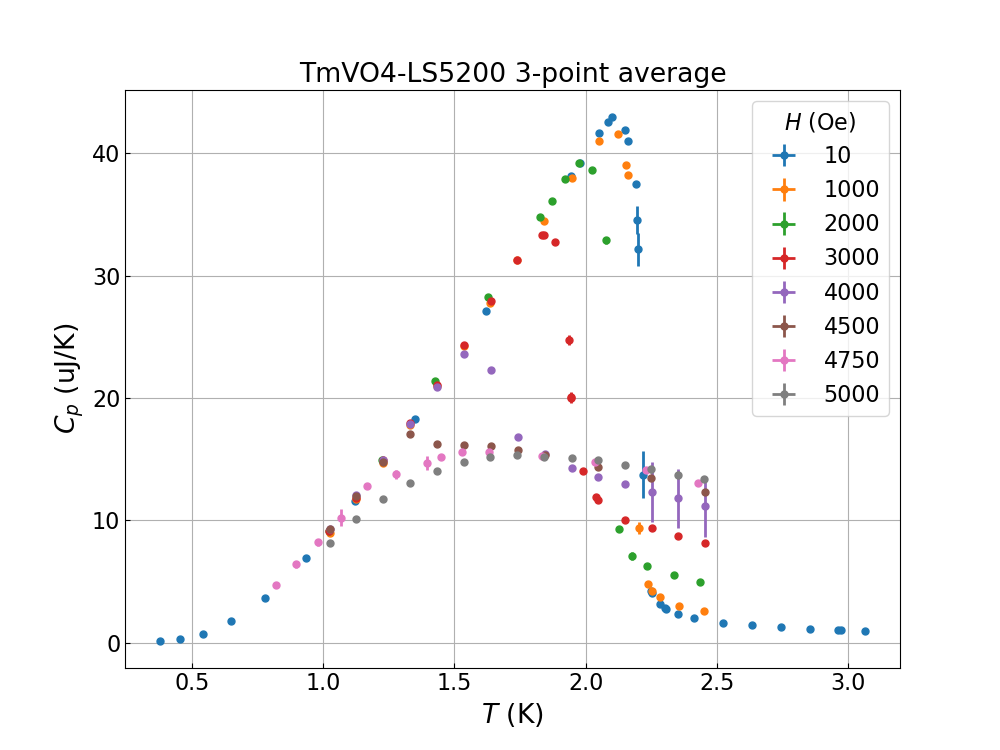

0 10.0
0 1000.0
0 2000.0
0 3000.0
0 4000.0
0 4500.0
0 4750.0
0 5000.0


<IPython.core.display.Javascript object>


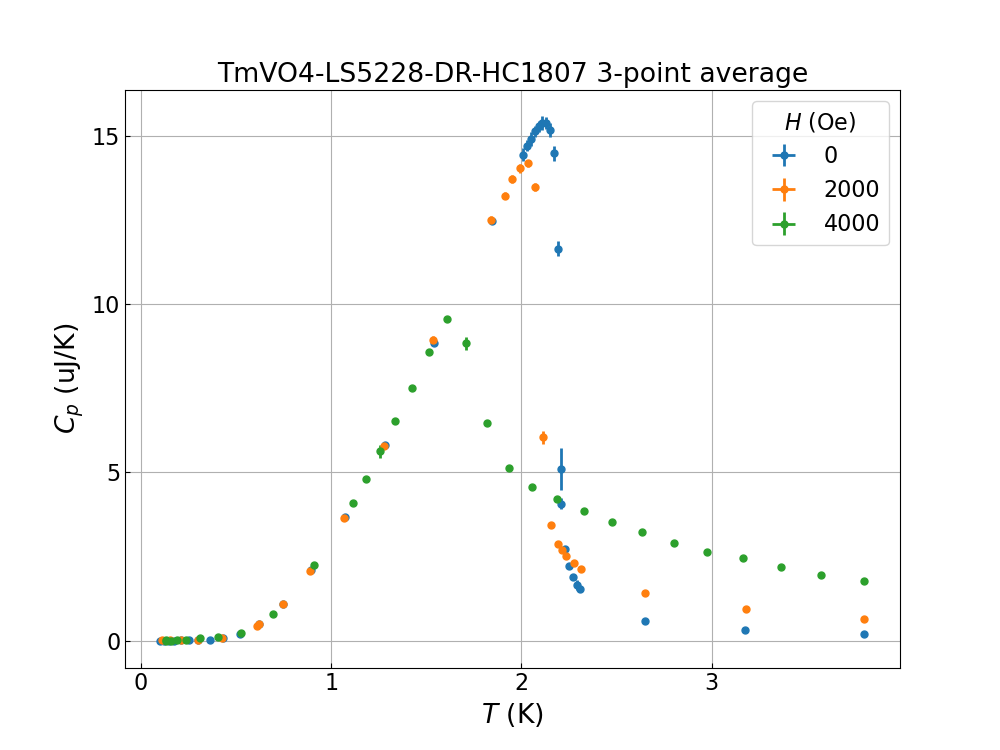

1 0.0
1 2000.0
1 4000.0


In [16]:
for idx in range(Nsamples):
    fig, ax = plt.subplots()
    cp_plot_settings(ax)
    plt.title(''.join([samples[idx], ' 3-point average']))
    for uh in uhcp[idx]:
        print(idx, uh)
        cpmhsel = np.where(np.round(Hm[idx])==uh)[0]
        plt.errorbar(Tm[idx].iloc[cpmhsel], Cpm[idx].iloc[cpmhsel], xerr=Tsd[idx].iloc[cpmhsel], yerr=CpmErr[idx].iloc[cpmhsel], 
                     marker='.', lw=0, elinewidth=2, label=round(uh))
    plt.legend(title=r'$H$ (Oe)')

#### First derivative of data

In [17]:
for var in ['H1m', 'T1m', 'T1sd', 'd1TCpm', 'd1TCpmErr', 'pbcp', 'pbcp_dict']:
    exec(f'{var} = [None]*Nsamples')

In [18]:
for idx in range(Nsamples):
    d1TCpm[idx] = Cpm[idx].diff()/Tm[idx].diff()# first derivative of the heat capacity data
    d1TCpmErr[idx] = CpmErr[idx].rolling(2).sum()# error on 1st derivative; the contribution from Tsd[idx] is ignored because it is negligible
    T1m[idx] = Tm[idx].rolling(2).mean()# mean temperature for plotting the first derivative of the heat capacity data
    H1m[idx] = Hm[idx].rolling(2).mean()# mean magnetic field for saving the critical temperature extracted from Cp data
    T1sd[idx] = Tsd[idx].rolling(2).sum()/np.sqrt(2)# error on mean temperature

In [19]:
for idx in range(Nsamples):
    pbcp_dict[idx] = {}
    for key in ['Hc (Oe)', 'Hc_inferred', 'Tc', 'Tc_Err (K)', 'min(dCp/dT) (uJ/K^2)']:
        pbcp_dict[idx][key] = [None]*len(uhcp[idx])

    for ih, uh in enumerate(uhcp[idx]):
        cpmhsel = np.logical_and(Hm[idx].round()==uh, T1m[idx]>1.)
        T1m_ = T1m[idx].where(cpmhsel)
        H1m_ = H1m[idx].where(cpmhsel)
        d1TCpm_ = d1TCpm[idx].where(cpmhsel)
        T1sd_ = T1sd[idx].where(cpmhsel)

        pbcp_dict[idx]['Hc (Oe)'][ih] = H1m_.loc[d1TCpm_.idxmin()]
        pbcp_dict[idx]['Hc_inferred'][ih] = pbcp_dict[idx]['Hc (Oe)'][ih]*mce_data[idx]['rhc'][0]
        pbcp_dict[idx]['Tc'][ih] = T1m_.loc[d1TCpm_.idxmin()]    
        pbcp_dict[idx]['Tc_Err (K)'][ih] = T1sd_.loc[d1TCpm_.idxmin()] +\
        abs(T1m[idx].iloc[d1TCpm_.argmin()-1]-T1m[idx].iloc[d1TCpm_.argmin()])/2
        pbcp_dict[idx]['min(dCp/dT) (uJ/K^2)'][ih] = d1TCpm_.min()

    pbcp[idx] = pd.DataFrame(pbcp_dict[idx])
    
pbcp[idx]

,Hc (Oe),Hc_inferred,Tc,Tc_Err (K),min(dCp/dT) (uJ/K^2)
0,0.151166,0.146329,2.200793,0.010084,-386.821601
1,2000.134500,1936.130196,2.093308,0.020277,-186.661032
2,4000.263050,3872.254632,1.764190,0.058452,-21.849187


In [20]:
pbcp[0] = pbcp[0].loc[:5].copy()

<IPython.core.display.Javascript object>


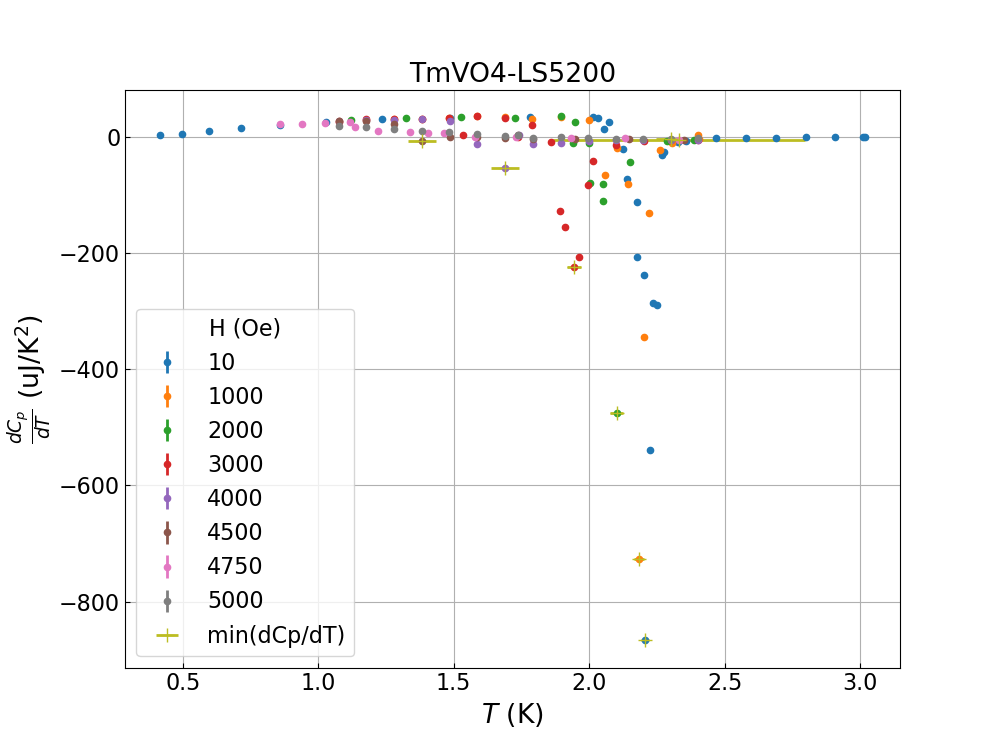

<IPython.core.display.Javascript object>


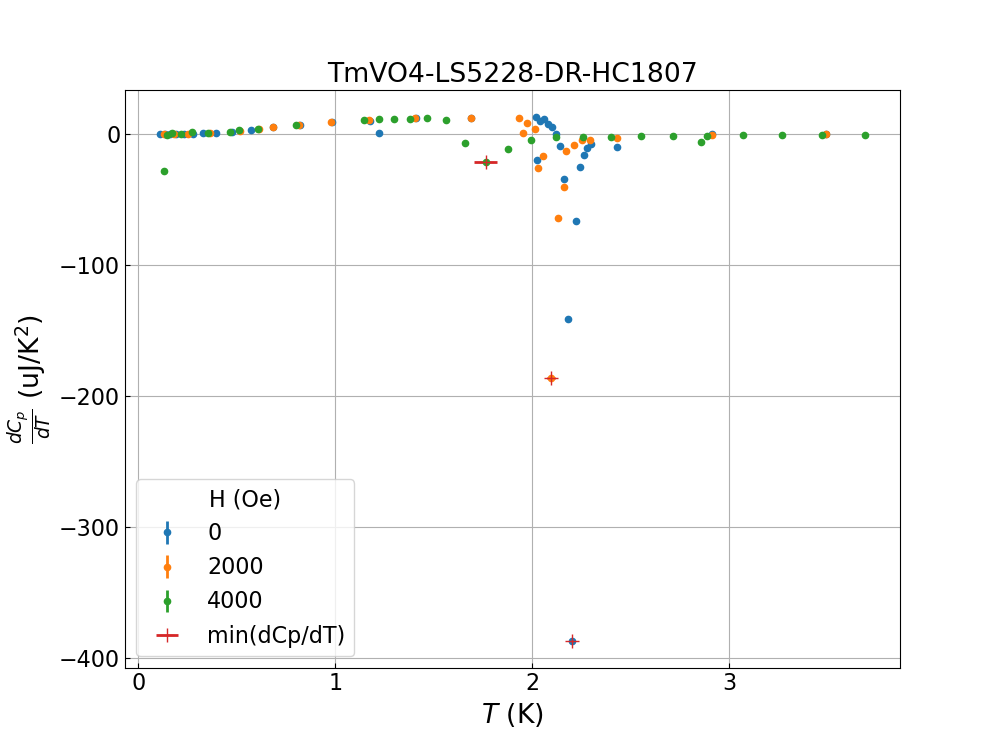

In [21]:
for idx in range(Nsamples):
    fig, ax = plt.subplots()
    cp_plot_settings(ax)
    plt.title(samples[idx])
    for uh in uhcp[idx]:
        cpmhsel = Hm[idx].round()==uh
        plt.errorbar(T1m[idx][cpmhsel], d1TCpm[idx][cpmhsel], yerr=d1TCpmErr[idx][cpmhsel], 
                     marker='.', ms=9, lw=0, elinewidth=2, label=round(uh))
    plt.errorbar(pbcp_dict[idx]['Tc'], pbcp_dict[idx]['min(dCp/dT) (uJ/K^2)'], 
                 xerr=pbcp_dict[idx]['Tc_Err (K)'], marker='+', lw=0, elinewidth=2, label='min(dCp/dT)')
    ax.set_ylabel(r'$\frac{dC_p}{dT}$ (uJ/K$^2$)')
    plt.legend(title='H (Oe)')

### Plot MCE data

<IPython.core.display.Javascript object>


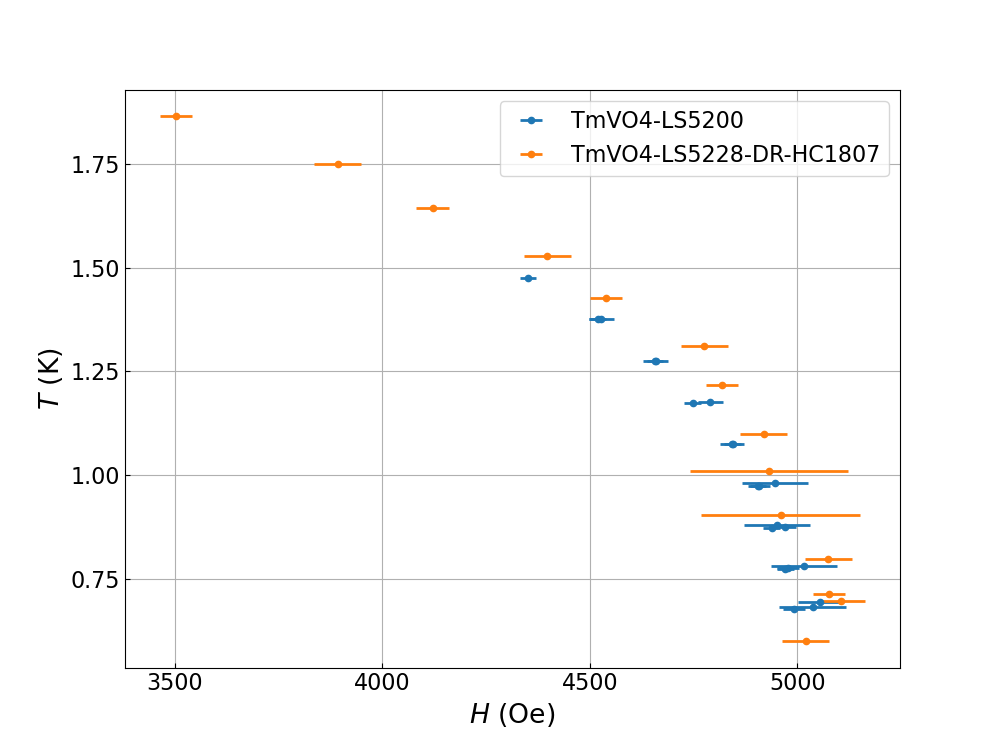

In [22]:
fig, ax = plt.subplots()
for idx in range(Nsamples):
    plt.errorbar(mce_data[idx]['Hc_inferred'], mce_data[idx]['Tc'], xerr=mce_data[idx]['dHc'], 
                 marker='.', ms=9, lw=0, elinewidth=2, label=f'{samples[idx]}')
ax.set_xlabel(r'$H$ (Oe)')
ax.set_ylabel(r'$T$ (K)')
ax.locator_params(nbins=6)
plt.legend()

## Fit data

### Fit with semi-classical model

In [23]:
def data_selection(data, temp_min=None, temp_max=None):
    if temp_max is None and temp_min is None:
        return np.ones(data.shape, dtype=bool)
    elif temp_max is None:
        return data>temp_min
    elif temp_min is None:
        return data<temp_max
    else:
        return np.logical_and(data>temp_min, data<temp_max)

In [24]:
def sc_tfim(x):
    return x/np.arctanh(x)

def sc_tfim_residual(params, x, data, eps_data=None):
    pvals = params.valuesdict()
    Tc = pvals['Tc']
    Hc = pvals['Hc']
    
    model = Tc*sc_tfim(x/Hc)

    if eps_data is None:
        yres = (data-model)
    else:
        yres = (data-model)/eps_data
    return yres[~np.isnan(yres)]

In [25]:
pb = [None]*Nsamples
for idx in range(Nsamples):
    mce_data[idx]['Tc_Err (K)'] = 0
    pbcp[idx]['dHc'] = 0
    pb[idx] = pd.concat([pbcp[idx], mce_data[idx]], join='inner')
#     pb[idx]['rTc_Err'] = pb[idx]['Tc_Err (K)']/pb[idx]['Tc']
#     pb[idx]['rHc_Err'] = pb[idx]['dHc']/pb[idx]['Hc_inferred']
    pb[idx]['rErr'] = np.sqrt((pb[idx]['Tc_Err (K)']/pb[idx]['Tc'])**2 + (pb[idx]['dHc']/pb[idx]['Hc_inferred'])**2)

# pb[0]

In [26]:
# Function to compute coefficient of determination R^2 from a combination of data and fit result
def rsquare(data, lmfit_result, eps_data=None, adjusted=False):
    fit = lmfit_result
    RSS = fit.chisqr# residual sum of squares
    
    # Total sum of squares
    if eps_data is None:
        TSS = ((data - data.mean())**2).sum()
    else:
        TSS = (((data - data.mean())/eps_data)**2).sum()
    
    rsqr = 1 - RSS/TSS# R^2
    
    if adjusted is True:
        # adjusted r^2
        adjrsqr = 1 - (RSS/TSS)*(fit.ndata-1)/(fit.nfree)# where fit.nfree = fit.ndata - fit.nvarys
        return rsqr, adjrsqr
    else:
        return rsqr

In [39]:
# 1-out.chisqr/(((y-y.mean())/err)**2).sum()
# rsquare(y, out, eps_data=err, adjusted=True)
# out.residual*err[ysel],fit_residual[ysel]
sc_fit_list
out.params
for itest in (0,3,4):
    print(itest)

0
3
4


#### Perform fit and plot

<IPython.core.display.Javascript object>


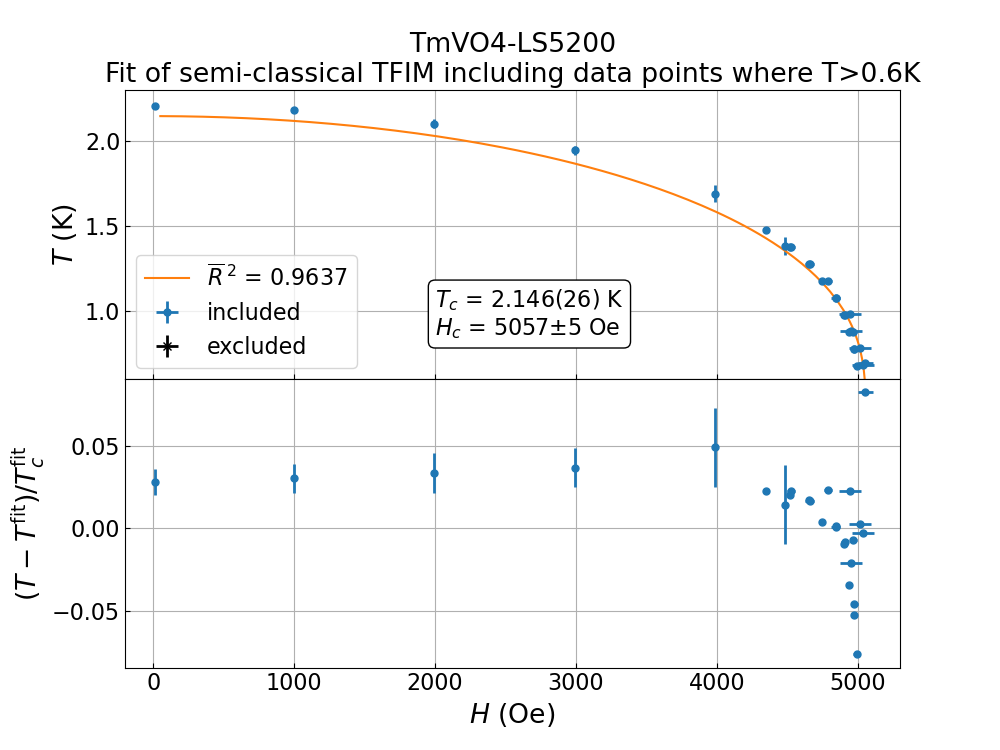

 Ndata:27; R^2:0.965091; adj-R^2:0.963694; Hc:5057.04; Hc_err:4.83858; Tc:2.14624; Tc_err:0.0263482;


<IPython.core.display.Javascript object>


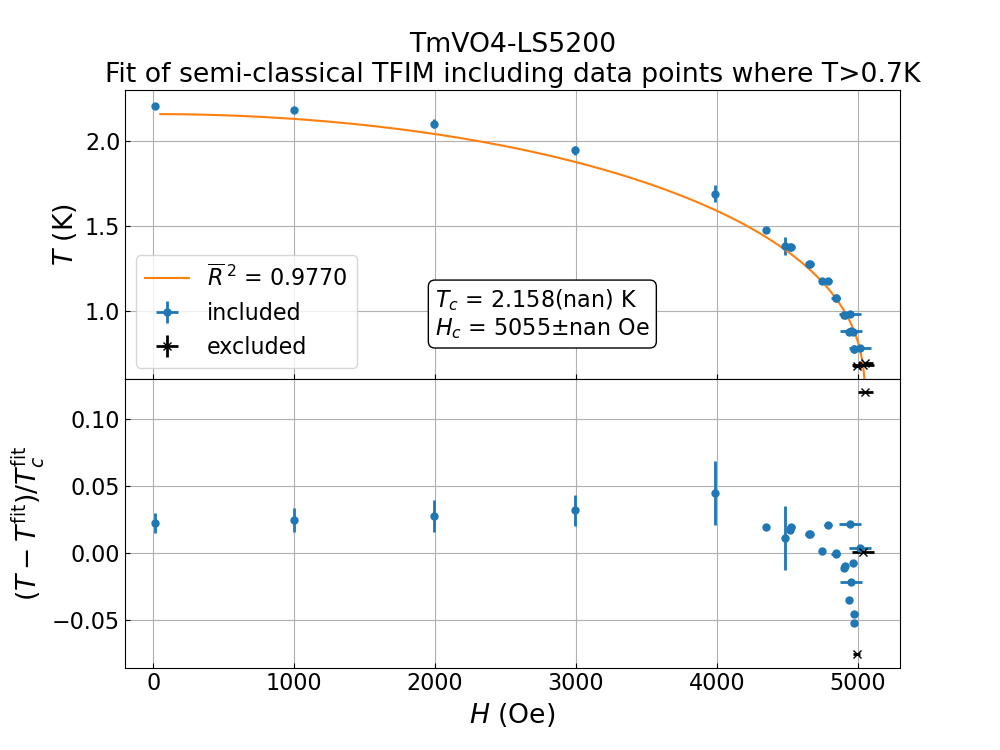

 Ndata:24; R^2:0.977979; adj-R^2:0.976978; Hc:5054.98; Hc_err:nan; Tc:2.15834; Tc_err:nan;


<IPython.core.display.Javascript object>


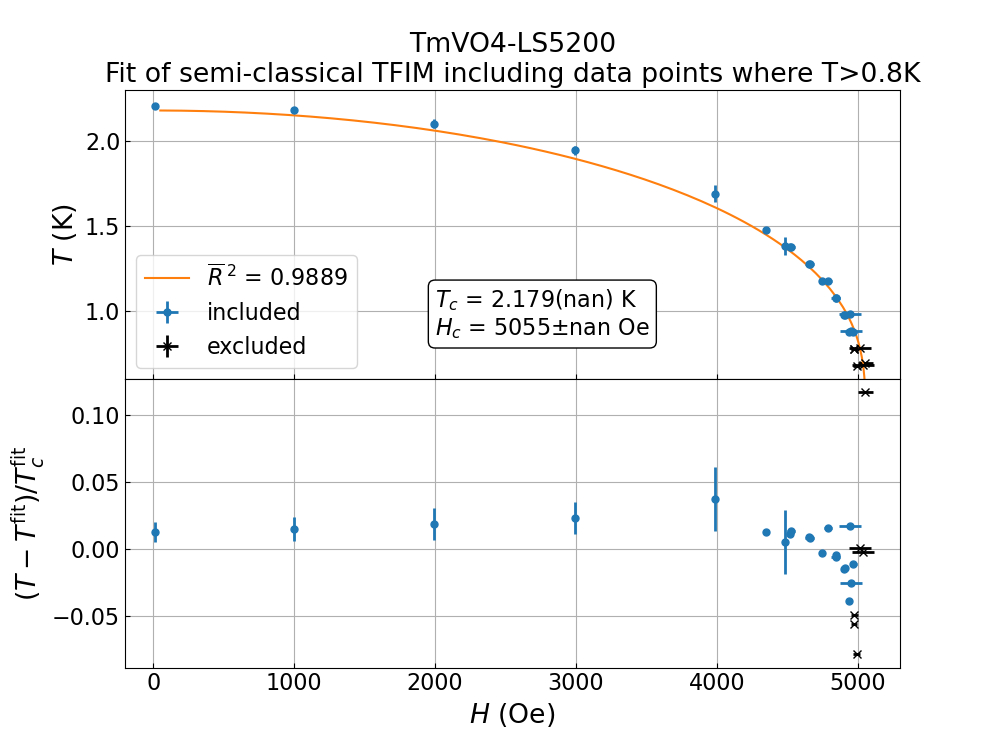

 Ndata:21; R^2:0.989462; adj-R^2:0.988908; Hc:5054.98; Hc_err:nan; Tc:2.17942; Tc_err:nan;


<IPython.core.display.Javascript object>


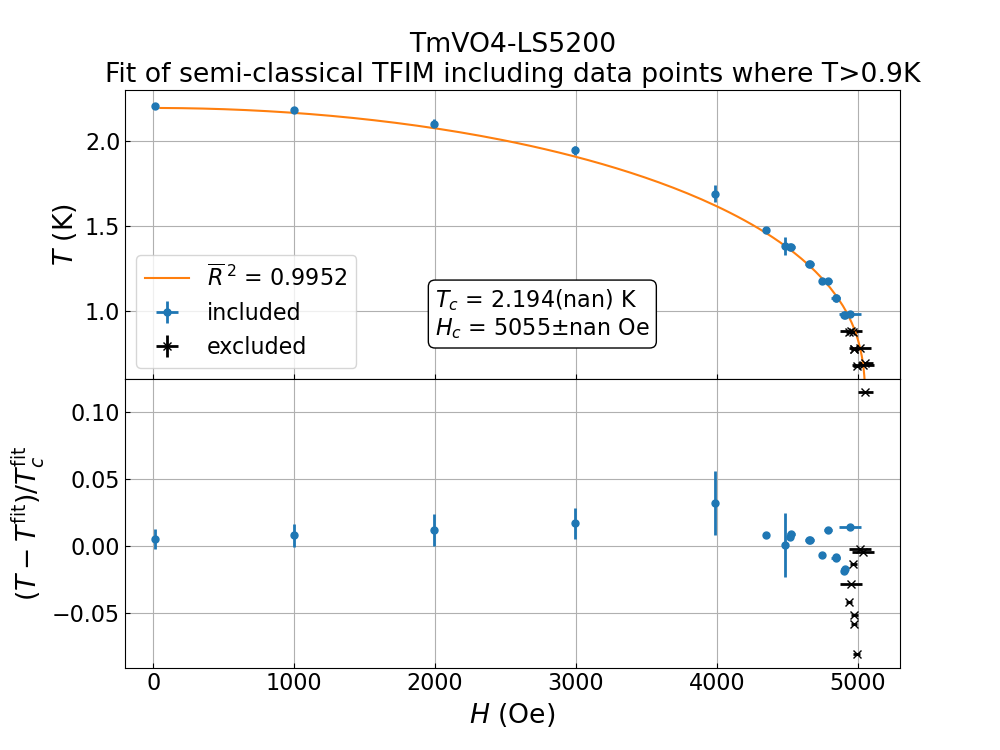

 Ndata:18; R^2:0.995493; adj-R^2:0.995211; Hc:5054.98; Hc_err:nan; Tc:2.19421; Tc_err:nan;


<IPython.core.display.Javascript object>


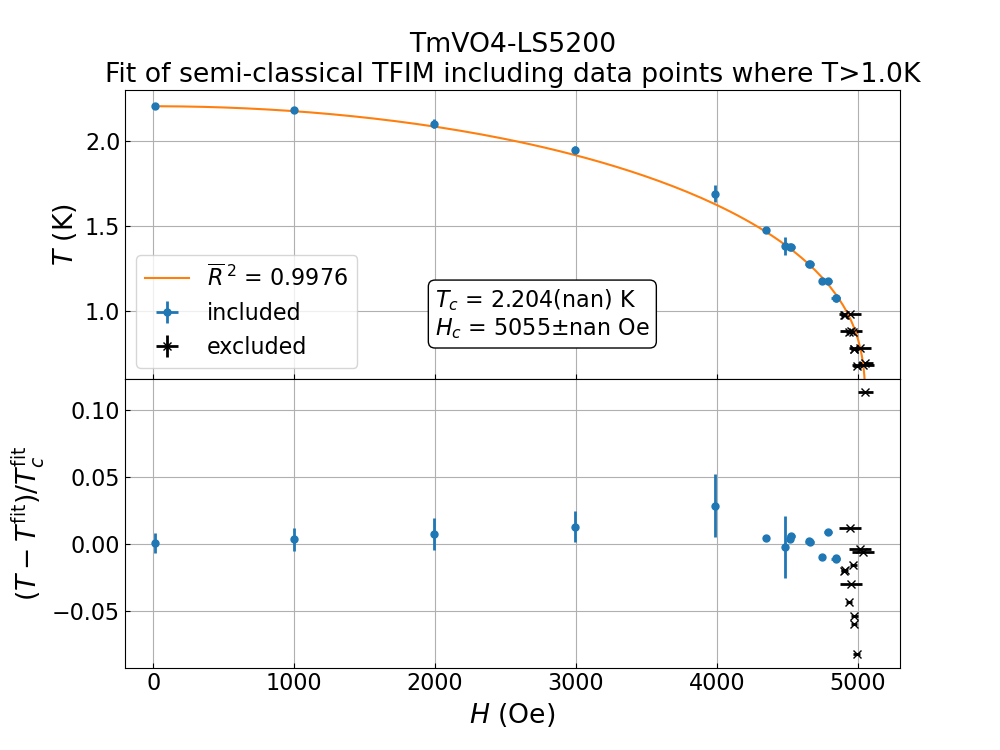

 Ndata:15; R^2:0.997812; adj-R^2:0.997644; Hc:5054.98; Hc_err:nan; Tc:2.20437; Tc_err:nan;


<IPython.core.display.Javascript object>


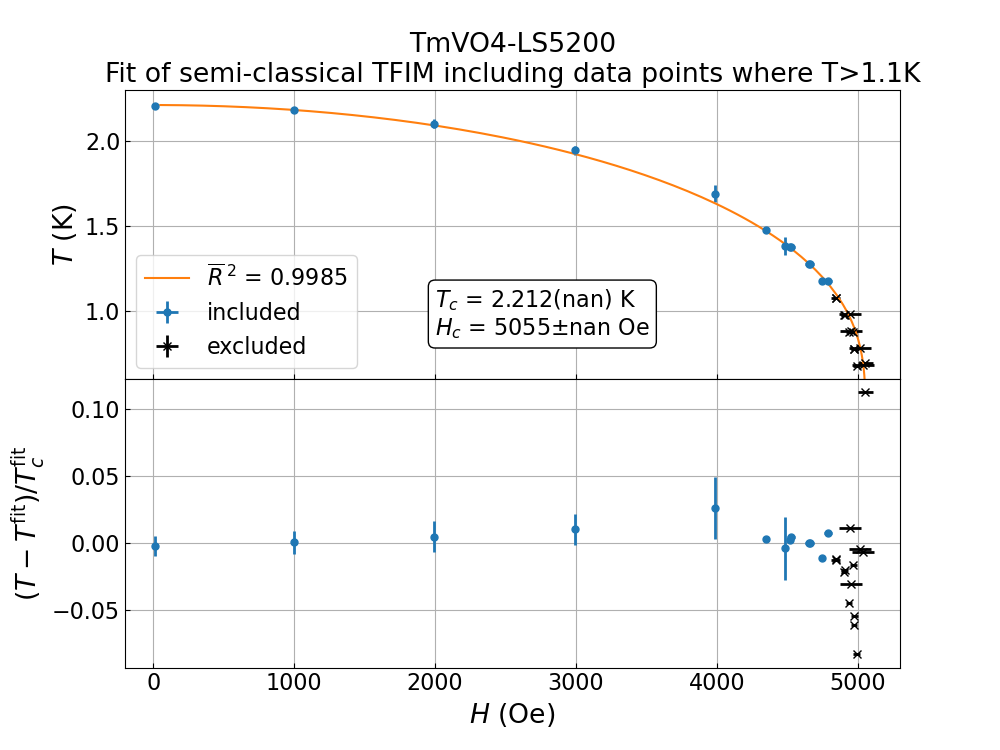

 Ndata:13; R^2:0.998633; adj-R^2:0.998509; Hc:5054.98; Hc_err:nan; Tc:2.21156; Tc_err:nan;


<IPython.core.display.Javascript object>


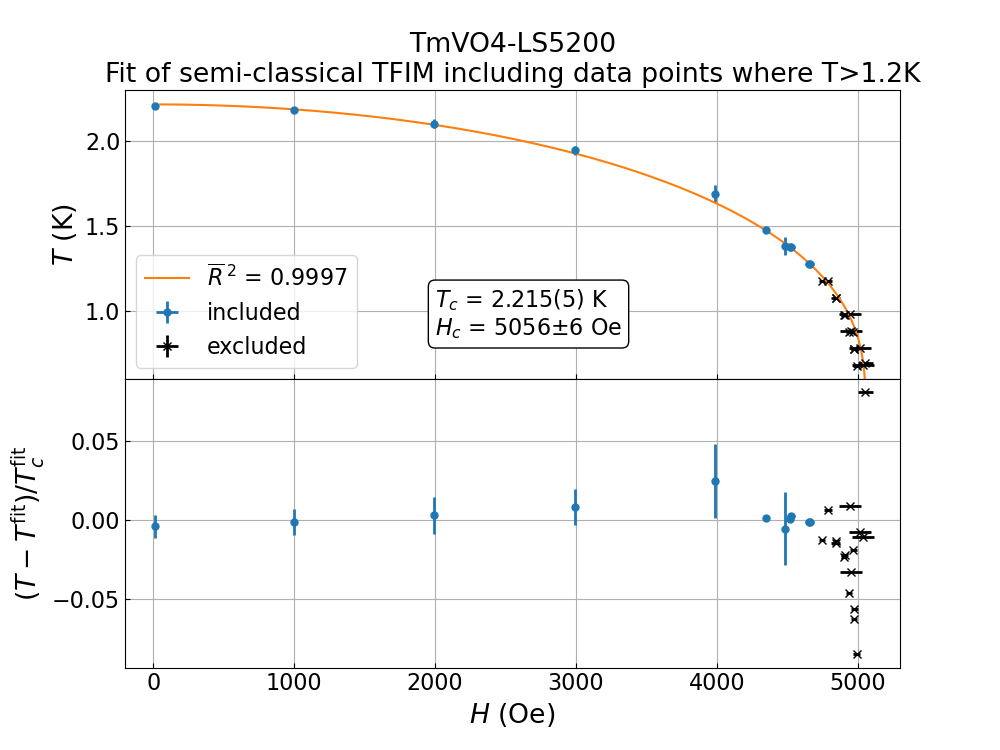

 Ndata:11; R^2:0.999701; adj-R^2:0.999668; Hc:5056.35; Hc_err:6.09366; Tc:2.21531; Tc_err:0.00481661;


<IPython.core.display.Javascript object>


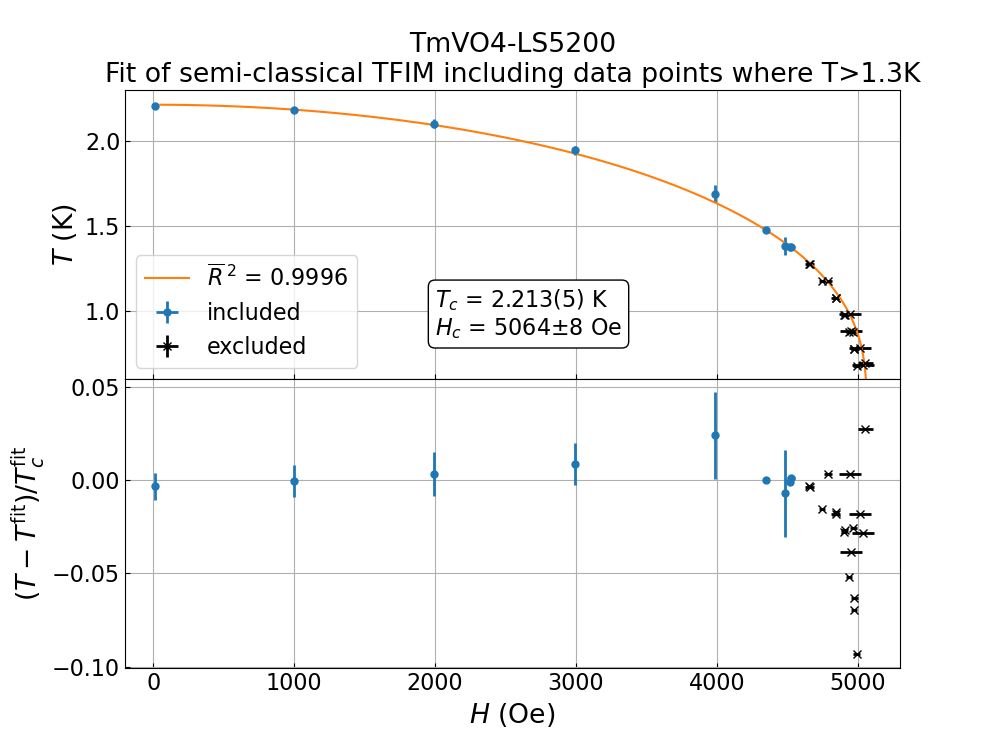

 Ndata:9; R^2:0.999666; adj-R^2:0.999619; Hc:5064.06; Hc_err:8.36865; Tc:2.21342; Tc_err:0.00503095;


<IPython.core.display.Javascript object>


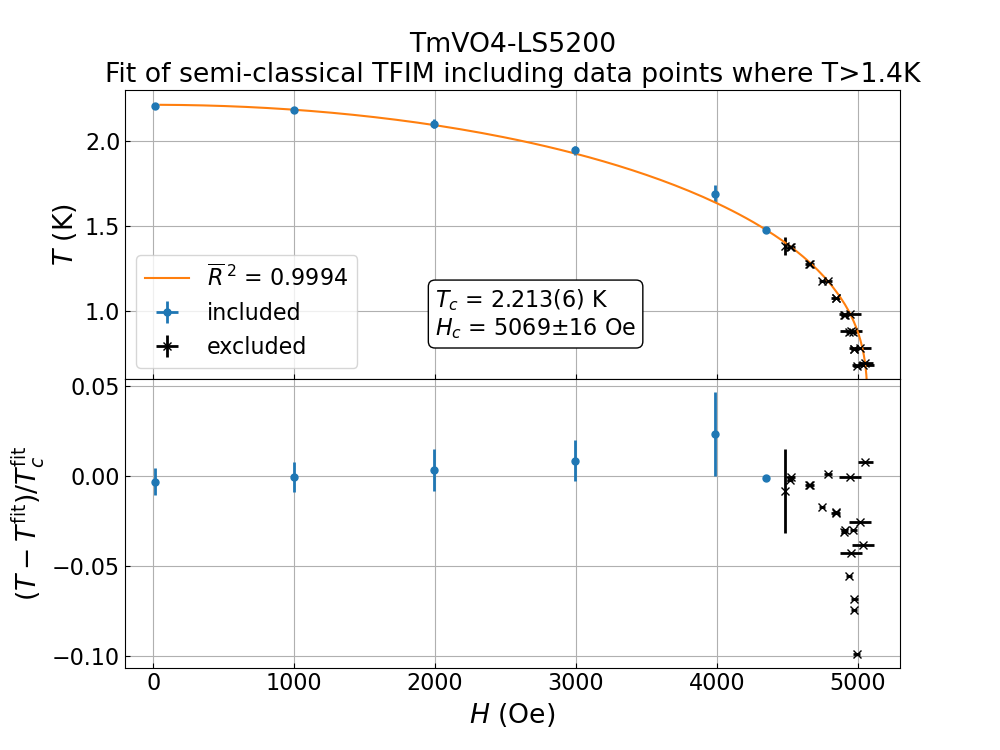

 Ndata:6; R^2:0.999491; adj-R^2:0.999364; Hc:5069.47; Hc_err:16.3974; Tc:2.21289; Tc_err:0.0063958;


<IPython.core.display.Javascript object>


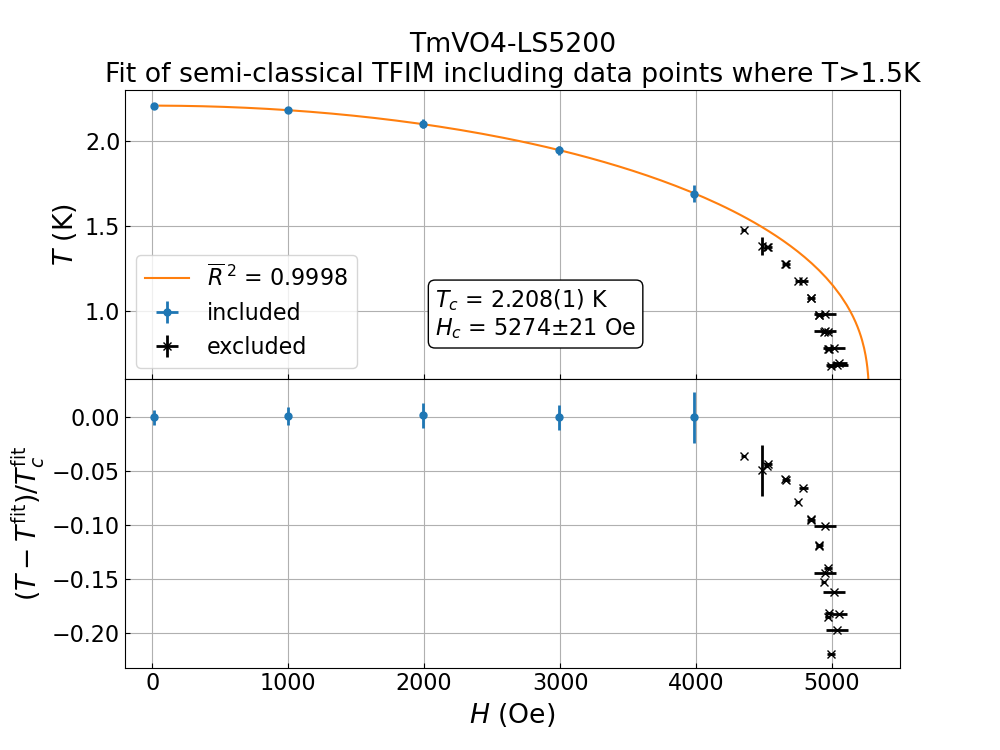

 Ndata:5; R^2:0.999862; adj-R^2:0.999816; Hc:5274.1; Hc_err:20.7244; Tc:2.20798; Tc_err:0.0012475;


<IPython.core.display.Javascript object>


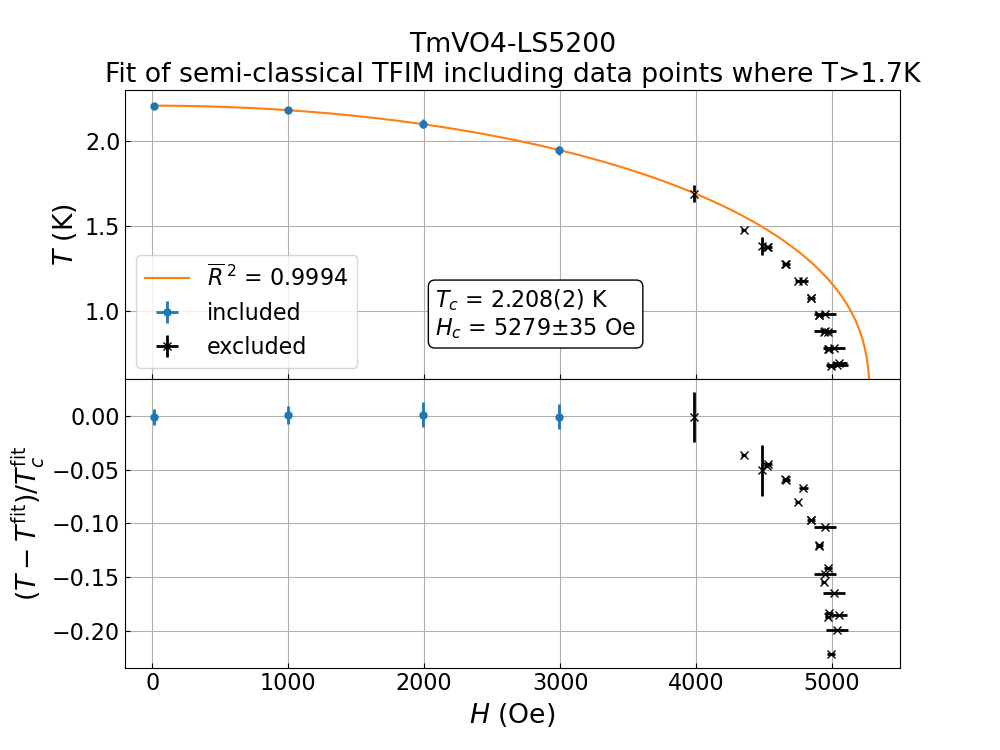

 Ndata:4; R^2:0.999622; adj-R^2:0.999433; Hc:5279.04; Hc_err:34.9587; Tc:2.20789; Tc_err:0.00157698;


<IPython.core.display.Javascript object>


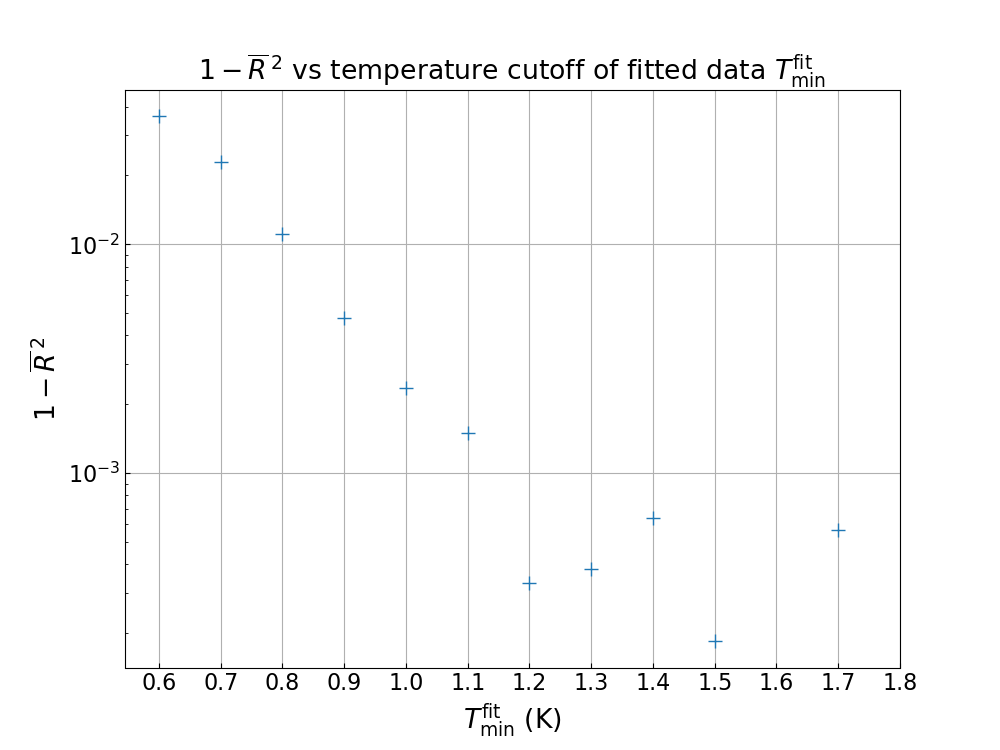

In [50]:
# Initialize fit parameters as lmfit's Parameters object
sc_params = Parameters()
sc_params.add('Tc', value=2.2, vary=True)

# Create list that will store fit results for data from each sample
sc_fit_list = [None]*Nsamples

for idx in range(1):
    # Data
    sample = samples[idx]
    Hc_data = pb[idx]['Hc_inferred']
    Tc_data = pb[idx]['Tc']
    yerr = pb[idx]['Tc_Err (K)']
    xerr = pb[idx]['dHc']
    err = pb[idx]['rErr']
    
    # Initialize Hc parameter
    sc_params.add('Hc', value=5.3e3, min=max(Hc_data)*1.0001, vary=True)# *1.0001 to avoid divergence of the result when best fit parameter is at bound
    
    # Initialize dictionary to store fit results
    sc_fit_list[idx] = {}

    # Range of values to use as base temperature of data selection
    sc_ylim = range(round(10*Tc_data.min()-.5), round(10*Tc_data.max()-4.5))# *10 because range only takes integer-like input
    sc_ylim_ = sc_ylim[:]# Subrange to loop over (mostly for test purposes)
    
    for ylim_idx, ylim10 in enumerate(sc_ylim_):
        # Data selection for fit 
        ylim = ylim10/10# base temperature of fit is 1/10 of ylim10 (by construction of sc_ylim)
        ysel = data_selection(Tc_data, temp_min=ylim)
        
        # If data selection is the same as in the previous iteration of the loop, skip to next iteration
        if ylim_idx>0 and np.array_equal(ysel, ysel_ref): continue
        ysel_ref = ysel# To compare data selection with that of next iteration
        
        # Perform fit of data using lmfit's minimize function
        try:
            out = minimize(sc_tfim_residual, sc_params, args=(Hc_data[ysel], Tc_data[ysel]), kws={'eps_data':err[ysel]})
        except ValueError as verr:
            print(verr)
            break

        # Extract fit parameters
        Tc_fit = out.params['Tc'].value
        Tc_fit_err = out.params['Tc'].stderr
        Hc_fit = out.params['Hc'].value
        Hc_fit_err = out.params['Hc'].stderr
        rsqr, adjrsqr = rsquare(Tc_data[ysel], out, eps_data=err[ysel], adjusted=True)
        
        # Store fit parameters
        sc_fit_list[idx][ylim] = {'Ndata':out.ndata, 'R^2':rsqr, 'adj-R^2':adjrsqr, 
                                  'Hc':Hc_fit, 'Hc_err':np.nan, 'Tc':Tc_fit, 'Tc_err':np.nan}
        if Hc_fit_err is not None:
            sc_fit_list[idx][ylim]['Hc_err'] = Hc_fit_err
            sc_fit_list[idx][ylim]['Tc_err'] = Tc_fit_err

        # Compute fit curve
        xfit = np.concatenate([np.linspace(.01,.96,96), 1-np.logspace(-1.5,-5)]) * Hc_fit
        yfit = Tc_fit * sc_tfim(xfit/Hc_fit)

        # Create figure + axes
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

        # Plot data + fit
        title = f'Fit of semi-classical TFIM including data points where T>{ylim}K'# Plot title
        plot_fitted_data(ax1, (Hc_data, Tc_data, xerr, yerr), ysel, Hc_fit)
        ax1.plot(xfit, yfit, label=f'$\overline{{R}}\,^2$ = {adjrsqr:.4f}')
        ax1.set_title(''.join([sample, '\n', title]))
        ax1.legend()
        ax1.annotate(''.join([f'$T_c$ = {Tc_fit:.3f}({sc_fit_list[idx][ylim]["Tc_err"]*1e3:.0f}) K\n',
                     f'$H_c$ = {Hc_fit:.0f}$\pm${sc_fit_list[idx][ylim]["Hc_err"]:.0f} Oe']), 
                     xy=(.4, .15), xycoords='axes fraction', 
                     bbox=dict(boxstyle='round', fc='w'))# add annotation

        # Plot residual
        fit_residual = sc_tfim_residual(out.params, Hc_data, Tc_data, eps_data=None)
        plot_fit_residual(ax2, (Hc_data, fit_residual/Tc_fit, xerr, yerr/Tc_fit), ysel)

        # Print fit parameters
        fit_prms = ''.join([f' {k}:{v:.6g};' for k, v in sc_fit_list[idx][ylim].items()])
        print(fit_prms)
        
    # 
    Tfit, Rsqr = zip(*[(ylim, 1-sc_fit_list[idx][ylim]['adj-R^2']) for ylim in sc_fit_list[idx].keys()])
    fig, ax = plt.subplots()
    ax.plot(Tfit, Rsqr, '+')
    ax.set_yscale('log')
    ax.set_title(r'$1-\overline{{R}}\,^2$ vs temperature cutoff of fitted data $T^{\mathrm{fit}}_{\mathrm{min}}$')
    ax.set_ylabel(r'$1-\overline{{R}}\,^2$')
    ax.set_xlabel(r'$T^{\mathrm{fit}}_{\mathrm{min}}$ (K)')
#     ax.locator_params(nbins=6, axis='x')
    ax.xaxis.set_ticks(np.arange(sc_ylim_[0]/10, (sc_ylim_[-1]+1)/10, 0.1))
#     ax.tick_params(which='both', direction='in')
#     ax.grid(b=True)

In [194]:
os.chdir(mce_data_dir[sample])
print(sample, os.getcwd())
saveFitFig = f'{str(today)}_{sample}_sc_fit.png'
plt.figure(num=10)
# plt.savefig(saveFitFig, dpi=200, bbox_inches='tight')
# plt.figure(num=12)
# saveRsqrFig = f'{str(today)}_{sample}_sc_fit_Rsqr.png'
# plt.savefig(saveRsqrFig, dpi=200, bbox_inches='tight')

TmVO4-LS5200 C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2017-07_TmVO4_Cp_MCE\2017-07-28--31\Massaic_MCE\Extracted_critical_fields


#### Conclusion
Best fit for sample LS5200 is for Tmin = 1.1 K, but good for all choices of Tmin
Best fit for sample LS5200 is for Tmin = 0.9 K

### Fit with Rafael's predictions

In [51]:
def rmf_model(x, A, Hc, psi):
    return A*abs(Hc-x)**psi

def rmf_residual(params, x, y, psi=.5, weights=None):
    """Compute the residual for fit using Rafael M. Fernandes' theoretical predictions."""
    pvals = params.valuesdict()
    A = pvals['A']
    Hc = pvals['Hc']
    
    model = A*abs(Hc-x)**psi

    if weights is None:
        yres = (y-model)
    else:
        yres = (y-model)*weights
        
    return yres[~np.isnan(yres)]

#### Fit plot functions

In [74]:
def plot_fitted_data(ax, data, data_selection, Hc_fit):
    Hc_data, Tc_data, Hc_err, Tc_err = data
    ax.errorbar(Hc_data[data_selection], Tc_data[data_selection], 
                xerr=Hc_err[data_selection], yerr=Tc_err[data_selection], 
                marker='.', lw=0, elinewidth=2, label='included')
    ax.errorbar(Hc_data[~data_selection], Tc_data[~data_selection], 
                xerr=Hc_err[~data_selection], yerr=Tc_err[~data_selection], 
                marker='x', ms=6, color='k', lw=0, elinewidth=2, label='excluded')
    ax.set_xlim([round(np.min(Hc_data)-2e2, -2), round(Hc_fit+2e2, -2)])
    ax.set_ylim([round(np.min(Tc_data)-.05, 1), round(np.max(Tc_data)+.05, 1)])
    ax.set_ylabel(r'$T$ (K)')

def plot_fit_residual(ax, data, data_selection, plot_excluded=True):
    Hc_data, fit_residual, Hc_err, Tc_err = data
    ax.errorbar(Hc_data[data_selection], fit_residual[data_selection], 
                xerr=Hc_err[data_selection], yerr=Tc_err[data_selection],
                marker='.', lw=0, elinewidth=2)
    if plot_excluded is True:
        ax.errorbar(Hc_data[~data_selection], fit_residual[~data_selection], 
                    xerr=Hc_err[~data_selection], yerr=Tc_err[~data_selection],
                    marker='x', ms=6, color='k', lw=0, elinewidth=2)
    ax.axhline(color='0.5', ls='--')#'0.5' is gray
    pb_plot_settings(ax)# see definition above
    ax.set_ylabel(r'$(T-T^{\mathrm{fit}})/T_c^{\mathrm{fit}}$')


#### Perform fit and plot

<IPython.core.display.Javascript object>


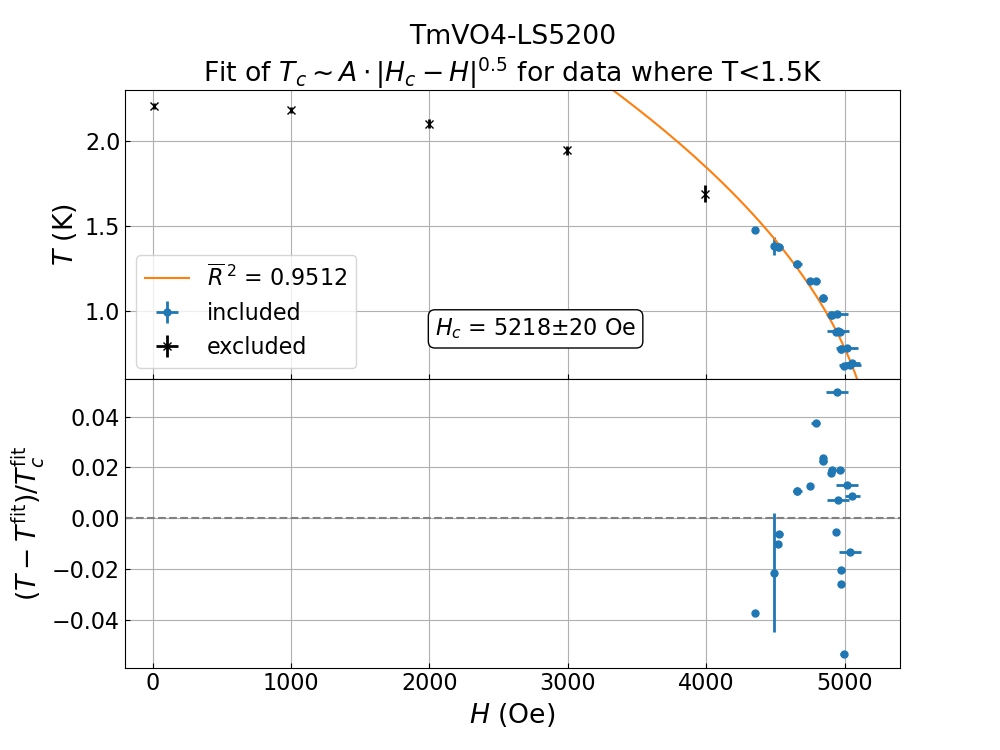

 Ndata:22; R^2:0.953487; adj-R^2:0.951162; Hc:5218.13; Hc_err:20.0267; A:0.0528504; A_err:0.00138271;


In [75]:
rmf_params = Parameters()
rmf_params.add('A', value=1)# arbitrary multiplying factor
rmf_params.add('Hc', value=5.2e3)# Critical field
psi = .5# exponent of power law fit
Tc = 2.2# estimated Tc, for plotting the fit residual

rmf_fit_list = [None]*2

rmf_ylim = [1.5, 1.2]

for idx in range(1):
    # Data
    sample = samples[idx]
    Hc_data = pb[idx]['Hc_inferred']
    Tc_data = pb[idx]['Tc']
    Tc_err = pb[idx]['Tc_Err (K)']
    Hc_err = pb[idx]['dHc']
    err = pb[idx]['rErr']
    
    ysel = data_selection(Tc_data, temp_max=rmf_ylim[idx], temp_min=None)

#     rmf_ylim = [round(np.min(y)+.25,1)]
    rmf_fit_list[idx] = {}

#     while rmf_ylim[-1]<1.7:
#         if rmf_ylim[-1]>np.max(y): break

    # Perform fit
    try:
        out = minimize(rmf_residual, rmf_params, args=(Hc_data[ysel], Tc_data[ysel]), 
                       kws={'psi':psi, 'weights':1/err[ysel]}, nan_policy='omit')
    except ValueError as verr:
        print(verr)
        break

    A_fit = out.params['A'].value
    A_fit_err = out.params['A'].stderr
    Hc_fit = out.params['Hc'].value
    Hc_fit_err = out.params['Hc'].stderr
    rsqr, adjrsqr = rsquare(Tc_data[ysel], out, eps_data=err[ysel], adjusted=True)

    # Store fit parameters
    rmf_fit_list[idx] = {'Ndata':out.ndata, 'R^2':rsqr, 'adj-R^2':adjrsqr, 
                         'Hc':Hc_fit, 'Hc_err':Hc_fit_err, 'A':A_fit, 'A_err':A_fit_err}

    # Compute fit curve
    xfit = np.concatenate([np.linspace(0,.96,97),1-np.logspace(-1.5,-5)]) * Hc_fit
    yfit = rmf_model(xfit, A_fit, Hc_fit, psi)#A_fit*(Hc_fit-xfit)**psi

    # Create figure + axes
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    # Plot data + fit
    title = f'Fit of $ T_c \sim A \cdot | H_c - H | ^{{{psi}}}$ for data where T<{rmf_ylim[idx]}K'# Plot title
    plot_fitted_data(ax1, (Hc_data, Tc_data, Hc_err, Tc_err), ysel, Hc_fit)
    ax1.plot(xfit, yfit, label=f'$\overline{{R}}\,^2$ = {adjrsqr:.4f}')
    ax1.set_title(''.join([sample, '\n', title]))
    ax1.legend()
    ax1.annotate(''.join([f'$H_c$ = {Hc_fit:.0f}$\pm${rmf_fit_list[idx]["Hc_err"]:.0f} Oe']), 
                 xy=(.4, .15), xycoords='axes fraction', 
                 bbox=dict(boxstyle='round', fc='w'))# add annotation

    # Plot residual
    fit_residual = rmf_residual(out.params, Hc_data, Tc_data, psi=psi, weights=None)
    plot_fit_residual(ax2, (Hc_data, fit_residual/Tc, xerr, yerr/Tc), ysel, plot_excluded=False)

    # Print fit parameters
    fit_prms = ''.join([f' {k}:{v:.6g};' for k, v in rmf_fit_list[idx].items()])
    print(fit_prms)


#### Conclusion
- Best fit for sample LS5200 is for Tmax = 1.3K
- Best fit for sample LS5228 is for Tmax = 1.4K

#### To do as of 2021-05-31
Convert code to a function and apply for psi = 1/4, 2/5 and 2/3